<a href="https://colab.research.google.com/github/rafaelatiengo/Raoq_GEE/blob/main/Rao_GEE_Tiengoetal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

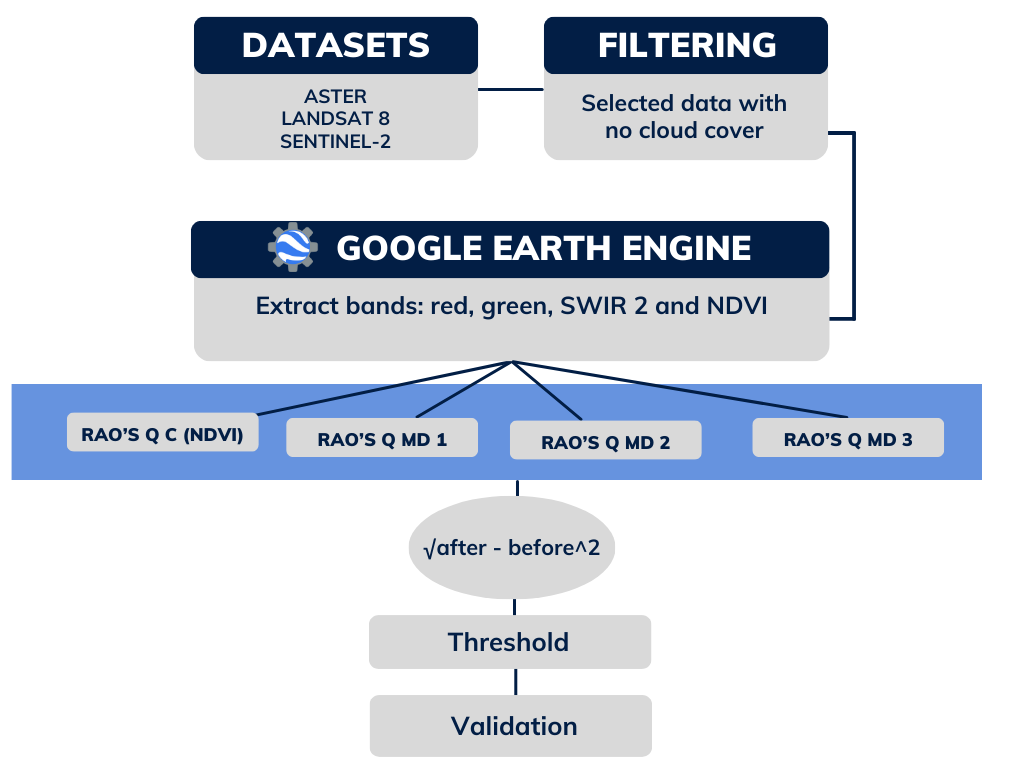

# **Google Earth Engine (GEE)**



## Install libraries

In [ ]:
!pip install geemap pycrs geopandas rasterio -q

## Import libraries

In [ ]:
# Import libraries
import geemap
import ee
import os
import numpy as np
import rasterio
from osgeo import gdal, ogr, osr

In [ ]:
# Sign in to Google Earth Engine
ee.Authenticate()
ee.Initialize(project='gee-ait-408415')

## Drive mount

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# **Area of interest**

## Using pre defined area

In [ ]:
# Defining Area of Interest (AOI)
aoi = ee.Geometry.Polygon(
  [[[-25.216361242931516, 37.77970798114115],
          [-25.216361242931516, 37.77075279958823],
          [-25.203658301036985, 37.77075279958823],
          [-25.203658301036985, 37.77970798114115]]], None, False)

## Import shapefile

In [ ]:
# Center the map on Azores
Map = geemap.Map(center=[37.81005519477107,-25.225982666015625], zoom=12, layer_ctrl=True)
Map.add_basemap('SATELLITE')
# Import the shapefiles from drive
priolo = geemap.shp_to_ee(r"/content/drive/MyDrive/Second Paper PhD/SHAPEFILES_LIFE/Shapes_LIFEs_SPEA_ZPE P.Vara/LIFE_Priolo.shp")
prioloprovisorio = geemap.shp_to_ee(r"/content/drive/MyDrive/Second Paper PhD/SHAPEFILES_LIFE/Shapes_LIFEs_SPEA_ZPE P.Vara/LIFE_Terras_do_Priolo(provisorio).shp")
laurissilva = geemap.shp_to_ee(r"/content/drive/MyDrive/Second Paper PhD/SHAPEFILES_LIFE/Shapes_LIFEs_SPEA_ZPE P.Vara/LIFE_Laurissilva_Sust.shp")
c4_3 = geemap.shp_to_ee(r"/content/drive/MyDrive/Second Paper PhD/SHAPEFILES_LIFE/Areas_LIFEIP/C4_3_Areas_Mar2021.shp")
c5_total = geemap.shp_to_ee(r"/content/drive/MyDrive/Second Paper PhD/SHAPEFILES_LIFE/Areas_LIFEIP/C5_total_9nov21.shp")


# Add to the map in red color
Map.addLayer(priolo, {'color': 'red'}, name='Priolo')
Map.addLayer(laurissilva, {'color': 'green'}, name='Laurissilva')
Map.addLayer(prioloprovisorio, {'color': 'blue'}, name='Priolo Provisorio')
Map.addLayer(c4_3, {'color': 'yellow'}, name='C4_3')
Map.addLayer(c5_total, {'color': 'orange'}, name='C5_total')

Map

## Using a map draw area

In [ ]:
#aoi = ee.FeatureCollection(Map.draw_features)

# **ASTER**

## Collection and process

In [ ]:
# Define the f_index_ function for calculating indices
def index_ASTER(image):
  ndvi =  image.normalizedDifference(['nir', 'red']).rename('NDVI'); # Rouse 1973
  ndwi = image.normalizedDifference(['green', 'nir']).rename ('NDWI'); # Mc Feeters 1996
  evi2 = image.expression('2.4 * ((N - R) / (N + R + 1))', { # Miura et al. 2008
        'N': image.select('nir'), 'R': image.select('red')}).rename('EVI');
  rgr = image.expression('R / G', { # Simple Ratio Green Red
        'G': image.select('green'), 'R': image.select('red')}).rename('RGR');
  CIgreen =  image.expression('N/G -1', { # https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2005GL022688
        'N': image.select('nir'), 'G': image.select('green')}).rename('CIgreen');
  savi = image.expression('(1 + L ) * float(nir - red)/ (nir + red + L)',{ 'nir': image.select('nir'),
        'red': image.select('red'),'L':1}).rename('SAVI');
  return image.addBands([ndvi,ndwi, evi2, savi, CIgreen, rgr])

In [ ]:
# Set the resize function
def rescale(img, exp, thresholds):
    return img.expression(exp, {'img': img}).subtract(thresholds[0]).divide(thresholds[1] - thresholds[0])


# Define the Aster class
class Aster:
    @staticmethod
    def radiance_from_DN(image):
        # Gain coefficients are dynamic (high, normal, low_1 or low_2)
        multiplier = ee.Image([
            ee.Number(image.get('GAIN_COEFFICIENT_B01')),
            ee.Number(image.get('GAIN_COEFFICIENT_B02')),
            ee.Number(image.get('GAIN_COEFFICIENT_B3N')),
        ])

        # Apply correction
        radiance = image.select(['green','red','nir']) \
            .subtract(1).multiply(multiplier)\

        # Define necessary properties for calculating reflectance
        solar_z = ee.Number(90).subtract(image.get('SOLAR_ELEVATION'))

        return radiance.set({
            'system:time_start': image.get('system:time_start'),
            'solar_zenith': solar_z
        })

    @staticmethod
    def reflectance_from_rad(rad):
        # Calculate day of year from timestamp
        date = ee.Date(rad.get('system:time_start'))
        jan01 = ee.Date.fromYMD(date.get('year'), 1, 1)
        doy = date.difference(jan01, 'day').add(1)

        # Distance Earth-Sun squared (d2)
        d = ee.Number(doy).subtract(4).multiply(0.017202).cos().multiply(-0.01672).add(1)
        d2 = d.multiply(d)

        # Mean exoatmospheric solar irradiance (ESUN)
        ESUN = [1847, 1553, 1118]

        # Cosine of the solar zenith angle (cosz)
        solar_z = ee.Number(rad.get('solar_zenith'))
        cosz = solar_z.multiply(3.14159).divide(180).cos()

        # Calculate reflectance
        scalarFactors = ee.Number(3.14159).multiply(d2).divide(cosz)
        scalarApplied = rad.multiply(scalarFactors)
        reflectance = scalarApplied.divide(ESUN)

        return reflectance


In [ ]:
#Bands and rename bands
asterBands = ee.List(['B01', 'B02', 'B3N', 'B04'])
outbandsAster = ee.List(['green', 'red', 'nir', 'swir1'])

In [ ]:
from datetime import datetime, timedelta

# Define the initial date as a string
date1 = '2014-03-01'

# Convert the string to a datetime object
date_obj = datetime.strptime(date1, '%Y-%m-%d')

# Advance the date by one day
date_advanced = date_obj + timedelta(days=1)

# Convert the advanced date back to a string in the 'YYYY-MM-DD' format
date_advanced_str = date_advanced.strftime('%Y-%m-%d')


In [ ]:
# Define the Aster collection
asterCollection = ee.ImageCollection('ASTER/AST_L1T_003')\
.filterBounds(ee.Geometry.Point([-25.225982666015625,37.81005519477107]))\
.filterDate(date1, date_advanced_str)\
.filter(ee.Filter.listContains('ORIGINAL_BANDS_PRESENT', 'B01'))\
.filter(ee.Filter.listContains('ORIGINAL_BANDS_PRESENT', 'B02'))\
.filter(ee.Filter.listContains('ORIGINAL_BANDS_PRESENT', 'B3N'))\
.select(asterBands, outbandsAster)\
.map(Aster.radiance_from_DN)\
.map(Aster.reflectance_from_rad)\
.map(index_ASTER)\


#print(asterCollection.first())


In [ ]:
image = asterCollection.first()  # Selects the first image in the collection
band_names = image.bandNames().getInfo()  # Gets the band names from the image
print(band_names)

In [ ]:
collection_info = asterCollection.mean().getInfo()
collection_info

In [ ]:
# Checking the date of our images
dateASTER = asterCollection.first().getInfo()
image_date = dateASTER['properties']['system:index']
print('Images list', image_date)

In [ ]:
# Names of the available bands for the analysis
asterCollection.first().bandNames().getInfo()

In [ ]:
#Styling bands
colors= ['green', 'darkgreen']
paletteNDVI = {'min': -1,
             'max': 1,
             'dimension': 512,
             'palette': colors
             }

In [ ]:
#Clip the image with aoi
asterClip = asterCollection.mean().clip(aoi)

In [ ]:
# Center the map on Azores
cx = -25.225982666015625
cy = 37.81005519477107

Map = geemap.Map(center=[cy, cx], zoom=12)
Map.add_basemap('SATELLITE')
Map.addLayer(aoi, {}, 'region of interest')
Map.addLayer(asterClip.select('RGR'), {},'RGR')
Map.addLayer(asterClip.select('red','green', 'nir'), {}, 'RGB')

Map

## Checking pixel number

In [ ]:
# Calculate the pixel count within the area of interest
pixel_count = asterClip.reduceRegion(reducer=ee.Reducer.count(), geometry=aoi, scale=30)

# Get pixel count value
pixel_count_value = pixel_count.getInfo()

print('Number of pixels in the area of interest:', pixel_count_value)

## Export raster if pixel number is more than 262144

In [ ]:
# Getting each band as an image.
NDVI_aster = asterClip.select('NDVI')
SAVI_aster = asterClip.select('SAVI')
EVI_aster = asterClip.select('EVI')
NIR_aster = asterClip.select('nir')
RED_aster = asterClip.select('red')
NDWI_aster = asterClip.select('NDWI')
GREEN_aster = asterClip.select('green')
RGR_aster = asterClip.select('RGR')

In [ ]:
# Creating names of files automatically
index_ndvi = 'ndvi_ASTER_Laurissilva_'
nameNDVI_aster = index_ndvi+image_date
nameNDVI_aster

index_evi = 'evi_ASTER_Laurissilva_'
nameEVI_aster = index_evi+image_date
nameEVI_aster

index_savi = 'savi_ASTER_Laurissilva_'
nameSAVI_aster = index_savi+image_date
nameSAVI_aster

index_nir = 'nir_ASTER_Laurissilva_'
nameNIR_aster = index_nir+image_date
nameNIR_aster

index_red = 'red_ASTER_Laurissilva_'
nameRED_aster = index_red+image_date
nameRED_aster

index_ndwi = 'ndwi_ASTER_Laurissilva_'
nameNDWI_aster = index_ndwi+image_date
nameNDWI_aster

index_green = 'green_ASTER_Laurissilva_'
nameGREEN_aster = index_green+image_date
nameGREEN_aster

index_RGR = 'RGR_ASTER_Laurissilva_'
nameRGR_aster = index_RGR+image_date
nameRGR_aster

In [ ]:
# Directory to save the image >>>>>> Falta corrigir para Second Paper PhD <<<<<<<
outdir = 'imagensAster'

In [ ]:
# Export NDVI
exportNDVI_aster = ee.batch.Export.image.toDrive(image=NDVI_aster,  # an object ee.Image.
                                     region=aoi,  # an object ee.Geometry.
                                     description='Mosaico_NDVIrev',
                                     folder= outdir,
                                     fileNamePrefix=nameNDVI_aster,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')
# Export EVI
exportEVI_aster = ee.batch.Export.image.toDrive(image=EVI_aster,  # an object ee.Image.
                                     region=aoi,  # an object ee.Geometry.
                                     description='Mosaico_NDVIrev',
                                     folder= outdir,
                                     fileNamePrefix=nameEVI_aster,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')
# Export NDVI
exportSAVI_aster = ee.batch.Export.image.toDrive(image=SAVI_aster,  # an object ee.Image.
                                     region=aoi,  # an object ee.Geometry.
                                     description='Mosaico_NDVIrev',
                                     folder= outdir,
                                     fileNamePrefix=nameSAVI_aster,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')
# Export NDWI
exportNDWI_aster = ee.batch.Export.image.toDrive(image=NDWI_aster,  # an object ee.Image.
                                     region=aoi,  # an object ee.Geometry.
                                     description='Mosaico_NDVIrev',
                                     folder= outdir,
                                     fileNamePrefix=nameNDWI_aster,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')
# Export RED
exportRED_aster = ee.batch.Export.image.toDrive(image=RED_aster,  # an object ee.Image.
                                     region=aoi,  # an object ee.Geometry.
                                     description='Mosaico_NDVIrev',
                                     folder= outdir,
                                     fileNamePrefix=nameRED_aster,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')
# Export GREEN
exportGREEN_aster = ee.batch.Export.image.toDrive(image=GREEN_aster,  # an object ee.Image.
                                     region=aoi,  # an object ee.Geometry.
                                     description='Mosaico_NDVIrev',
                                     folder= outdir,
                                     fileNamePrefix=nameGREEN_aster,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')
# Export NIR
exportNIR_aster = ee.batch.Export.image.toDrive(image=NIR_aster,  # an object ee.Image.
                                     region=aoi,  # an object ee.Geometry.
                                     description='Mosaico_NDVIrev',
                                     folder= outdir,
                                     fileNamePrefix=nameNIR_aster,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')
# Export RGR
exportRGR_aster = ee.batch.Export.image.toDrive(image=RGR_aster,  # an object ee.Image.
                                     region=aoi,  # an object ee.Geometry.
                                     description='Mosaico_NDVIrev',
                                     folder= outdir,
                                     fileNamePrefix=nameRGR_aster,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')


In [ ]:
# Start the Download
exportNDVI_aster.start()
exportEVI_aster.start()
exportSAVI_aster.start()
exportNDWI_aster.start()
exportRED_aster.start()
exportGREEN_aster.start()
exportNIR_aster.start()
exportRGR_aster.start()



In [ ]:
# Verify the statusexportNDVI_l8.status()
exportNDVI_aster.status()


# **Index function (L8 and S2)**

In [ ]:
# Define the f_index_ function for calculating indices
def index(image):
  ndvi =  image.normalizedDifference(['nir', 'red']).rename('NDVI'); # Rouse 1973
  lswi =  image.normalizedDifference(['nir', 'swir1']).rename('LSWI'); # Xiao 2002
  mndwi = image.normalizedDifference(['green', 'swir1']).rename('MNDWI'); # Xu 2005
  ndwi = image.normalizedDifference(['green', 'nir']).rename ('NDWI'); # Mc Feeters 1996
  rgr = image.expression('R / G', { # Simple Ratio Green Red
        'G': image.select('green'), 'R': image.select('red')}).rename('RGR');
  evi = image.expression('2.5 * ((N - R) / (N + (6 * R) - (7.5 * B) + 1))', { # Huete 2002
        'N': image.select('nir'), 'R': image.select('red'), 'B': image.select('blue')}).rename('EVI');
  savi = image.expression('(1 + L ) * float(nir - red)/ (nir + red + L)',{ 'nir': image.select('nir'),
        'red': image.select('red'),'L':1}).rename('SAVI');
  return image.addBands([ndvi,lswi, mndwi, ndwi, evi,savi, rgr])

# Landsat

## Collections and process

In [ ]:
#Cloud mask

def cloud_mask_c2_l7(image):
    dilated_cloud = (1 << 1)
    cloud = (1 << 3)
    cloud_shadow = (1 << 4)

    qa = image.select('QA_PIXEL')

    mask = qa.bitwiseAnd(dilated_cloud) \
             .And(qa.bitwiseAnd(cloud)) \
             .Or(qa.bitwiseAnd(cloud_shadow))

    mask2 = image.mask().reduce(ee.Reducer.min())

    return image.updateMask(mask.Not()).updateMask(mask2)

In [ ]:
# Define the cloud and cloud shadow mask function for Landsat 8 images
def fmask8(image):
    cloudShadowBitMask = 1 << 4
    cloudsBitMask = 1 << 3
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(qa.bitwiseAnd(cloudsBitMask).eq(0))
    return image.updateMask(mask) \
                .copyProperties(image, ["system:time_start"])

In [ ]:
#Reescale bands L5 and L7
def scaleFactor_l5_l7(image) :
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2);
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(149.0);

    return image.addBands(opticalBands, None, True)\
                .addBands(thermalBand, None, True)



In [ ]:
#Reescale bands L8

def scaleFactor(image):
    # Apply the scaling factors to the appropriate bands
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B10').multiply(0.00341802).add(149.0)

    # Replace the original bands with the escalations and apply the masks
    return image.addBands(opticalBands, None, True) \
                .addBands(thermalBands, None, True)


In [ ]:
# Define the TMaOLI function for harmonizing ETM+ to OLI
def TMaOLI(image):
    pendientes = ee.Image.constant([0.8474, 0.8483, 0.9047, 0.8462, 0.8937, 0.9071])
    ordorig = ee.Image.constant([0.0003, 0.0088, 0.0061, 0.0412, 0.0254, 0.0172])
    imgArm = image.select(['blue', 'green', 'red', 'nir', 'swir1', 'swir2']).multiply(pendientes).add(ordorig)
    return ee.Image(imgArm).addBands(image.select(['QA_PIXEL', 'temp']))

In [ ]:
def TMaOLI(image):
    pendientes = ee.Image.constant([0.8474, 0.8483, 0.9047, 0.8462, 0.8937, 0.9071])
    ordorig = ee.Image.constant([0.0003, 0.0088, 0.0061, 0.0412, 0.0254, 0.0172])

    img_arm = image.select(['blue', 'green', 'red', 'nir', 'swir1', 'swir2']) \
                   .multiply(pendientes).add(ordorig) \
                   .copyProperties(image, ["SOLAR_ZENITH_ANGLE",
                                             "system:time_start",
                                             "system:footprint",
                                             "satellite",
                                             "sensor",
                                             "tile",
                                             'fecha',
                                             'nubosidad'])

    return ee.Image(img_arm).addBands(image.select(['QA_PIXEL', 'temp']))

In [ ]:
# Name of the bands
l5Bands = ee.List(['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','ST_B6','SR_B7','QA_PIXEL'])
l5names = ee.List(['blue', 'green', 'red', 'nir', 'swir1', 'temp', 'swir2','QA_PIXEL'])
l7Bands = ee.List(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'ST_B6', 'SR_B7','QA_PIXEL'])
l7names = ee.List(['blue', 'green', 'red', 'nir', 'swir1', 'temp', 'swir2','QA_PIXEL'])
l8Bands = ee.List(['SR_B2','SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'ST_B10', 'SR_B7','QA_PIXEL'])
l8names = ee.List(['ultra blue', 'blue', 'green', 'red', 'nir', 'swir1', 'temp', 'swir2','QA_PIXEL'])
outbands = ee.List(['blue', 'green', 'red', 'nir', 'swir1', 'temp', 'swir2','QA_PIXEL'])

## Landsat 8

In [ ]:
# Filter and process Landsat images
l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').map(scaleFactor).filterBounds(aoi).filterDate('2020-04-10', '2020-04-11').select(l8Bands, outbands).map(index)

print(f'Number of images: {len(l8.getInfo()["features"])}')

In [ ]:
imagem_info = l8.first().getInfo()
imagem_info

In [ ]:
# Checking the date of our images
datel8 = l8.first().getInfo()
image_date = datel8['properties']['system:index']
print('Images list', image_date)

In [ ]:
# Names of the available bands for the analysis
l8.first().bandNames().getInfo()

In [ ]:
#clip images with aoi
l8Clip = l8.mean().clip(aoi)

In [ ]:
# Plot in RGB color composite

parameters = {'min': 0,
              'max': 0.1,
              'dimensions': 512,
              'bands': ['red', 'blue', 'green']
              }

In [ ]:
#Styling bands
cores = ['green', 'darkgreen']
paletteNDVI = {'min': 0.2,
             'max': 1,
             'dimension': 512,
             'palette': cores
             }

In [ ]:
# Center the map on Azores
Map = geemap.Map(center=[37.81005519477107,-25.225982666015625], zoom=12, layer_ctrl=True)
Map.add_basemap('SATELLITE')
Map.addLayer(l8.max().select('NDVI'), paletteNDVI, 'NDVI L8')
Map.addLayer(l8.median(), parameters, 'RGB L8')
Map.addLayer(aoi, {}, 'region of interest')
Map

## Landsat 7

In [ ]:
# Filter and process Landsat images
l7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2').map(scaleFactor_l5_l7).filterBounds(aoi).filterDate('2001-03-29', '2001-03-30').select(l7Bands, l7names).map(index)

print(f'Number of images: {len(l7.getInfo()["features"])}')

In [ ]:
imagem_info = l7.first().getInfo()
imagem_info

In [ ]:
# Checking the date of our images
datel7 = l7.first().getInfo()
image_date = datel7['properties']['system:index']
print('Images list', image_date)

In [ ]:
# Names of the available bands for the analysis
l7.first().bandNames().getInfo()

In [ ]:
l7Clip = l7.mean().clip(aoi)

In [ ]:
# Plot in RGB color composite

parameters = {'min': 0,
              'max': 0.1,
              'dimensions': 512,
              'bands': ['red', 'blue', 'green']
              }

In [ ]:
cores = ['green', 'darkgreen']
paletteNDVI = {'min': 0.2,
             'max': 1,
             'dimension': 512,
             'palette': cores
             }

In [ ]:
# Center the map on Azores
Map = geemap.Map(center=[37.81005519477107,-25.225982666015625], zoom=12, layer_ctrl=True)
Map.add_basemap('SATELLITE')
Map.addLayer(l7.max().select('NDVI'), paletteNDVI, 'NDVI L8')
Map.addLayer(l7.median(), parameters, 'RGB L8')
Map.addLayer(aoi, {}, 'region of interest')
Map

## Landsat 4-5

In [ ]:
# Filter and process Landsat images
l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').map(scaleFactor_l5_l7).filterBounds(aoi).filterDate('2010-10-24', '2010-10-25').select(l5Bands, l5names).map(index).map(TMaOLI)

print(f'Number of images: {len(l5.getInfo()["features"])}')

In [ ]:
imagem_info = l5.first().getInfo()
imagem_info

In [ ]:
# Checking the date of our images
datel5 = l5.first().getInfo()
image_date = datel5['properties']['system:index']
print('Images list', image_date)

In [ ]:
# Names of the available bands for the analysis
l5.first().bandNames().getInfo()

In [ ]:
l5Clip = l5.mean().clip(aoi)

In [ ]:
# Plot in RGB color composite

parameters = {'min': 0,
              'max': 0.1,
              'dimensions': 512,
              'bands': ['red', 'blue', 'green']
              }

In [ ]:
cores = ['green', 'darkgreen']
paletteNDVI = {'min': -1,
             'max': 1,
             'dimension': 512,
             'palette': cores
             }

In [ ]:
# Center the map on Azores
Map = geemap.Map(center=[37.81005519477107,-25.225982666015625], zoom=12, layer_ctrl=True)
Map.add_basemap('SATELLITE')
Map.addLayer(l5Clip.select('NDVI'), paletteNDVI, 'NDVI L5')
Map.addLayer(l7.max().select('NDVI'), paletteNDVI, 'NDVI L7')
Map.addLayer(l5Clip, parameters, 'RGB L8')
Map.addLayer(aoi, {}, 'region of interest')
Map

## Checking pixel number

In [ ]:
# Calcule a contagem de pixels dentro da área de interesse
pixel_count = l8Clip.reduceRegion(reducer=ee.Reducer.count(), geometry=aoi, scale=30)

# Obtenha o valor da contagem de pixels
pixel_count_value = pixel_count.getInfo()

print('Número de pixels na área de interesse:', pixel_count_value)

## Export raster if pixel number is more than 262144

In [ ]:
# Getting each band as an image.
NDVI_l8 = l5Clip.select('NDVI')
SAVI_l8 = l5Clip.select('SAVI')
EVI_l8 = l5Clip.select('EVI')
SWIR_l8 = l5Clip.select('swir1')
SWIR2_l8 = l5Clip.select('swir2')
NIR_l8 = l5Clip.select('nir')
RED_l8 = l5Clip.select('red')
GREEN_l8 = l5Clip.select('green')
BLUE_l8 = l5Clip.select('blue')
NDWI_l8 = l5Clip.select('NDWI')

In [ ]:
image_date = 'mean2013_2014'

In [ ]:
# Creating names of files automatically
index_ndvi = 'NDVI_'
index_savi = 'SAVI_'
index_evi = 'EVI_'
redBand = 'red_'
swirBand = 'swir1_'
swir2Band = 'swir2_'
nirBand = 'nir_'
greenBand = 'green_'
blueBand = 'blue_'
ndwiBand = 'ndwi_'
nameNDVI = index_ndvi+image_date
nameSAVI = index_savi+image_date
nameEVI = index_evi+image_date
nameRED = redBand+image_date
nameSWIR = swirBand+image_date
nameSWIR2 = swir2Band+image_date
nameNIR = nirBand+image_date
nameGREEN = greenBand+image_date
nameBLUE = blueBand+image_date
nameNDWI = ndwiBand+image_date
nameSAVI

In [ ]:
# Directory to save the image >>>>>> Falta corrigir para Second Paper PhD <<<<<<<
outdir = 'imagensL7'

In [ ]:
# Export NDVI
exportNDVI_l8 = ee.batch.Export.image.toDrive(image=NDVI_l8,  # an object ee.Image.
                                     region=aoi,  # an object ee.Geometry.
                                     description='Mosaico_NDVIrev',
                                     folder= outdir,
                                     fileNamePrefix=nameNDVI,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')
# Export SAVI
exportSAVI_l8 = ee.batch.Export.image.toDrive(image=SAVI_l8,  # an object ee.Image.
                                     region=aoi,  # an object ee.Geometry.
                                     description='Mosaico_NDVIrev',
                                     folder= outdir,
                                     fileNamePrefix=nameSAVI,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')
# Export EVI
exportEVI_l8 = ee.batch.Export.image.toDrive(image=EVI_l8,  # an object ee.Image.
                                     region=aoi,  # an object ee.Geometry.
                                     description='Mosaico_NDVIrev',
                                     folder= outdir,
                                     fileNamePrefix= nameEVI,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')
exportSWIR_l8 = ee.batch.Export.image.toDrive(image=SWIR_l8,  # an object ee.Image.
                                     region=aoi,  # an object ee.Geometry.
                                     description='Mosaico_NDVIrev',
                                     folder= outdir,
                                     fileNamePrefix=nameSWIR,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')
exportSWIR2_l8 = ee.batch.Export.image.toDrive(image=SWIR2_l8,  # an object ee.Image.
                                     region=aoi,  # an object ee.Geometry.
                                     description='Mosaico_NDVIrev',
                                     folder= outdir,
                                     fileNamePrefix=nameSWIR2,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')
# Export SAVI
exportRED_l8 = ee.batch.Export.image.toDrive(image=RED_l8,  # an object ee.Image.
                                     region=aoi,  # an object ee.Geometry.
                                     description='Mosaico_NDVIrev',
                                     folder= outdir,
                                     fileNamePrefix=nameRED,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')
# Export EVI
exportNIR_l8 = ee.batch.Export.image.toDrive(image=NIR_l8,  # an object ee.Image.
                                     region=aoi,  # an object ee.Geometry.
                                     description='Mosaico_NDVIrev',
                                     folder= outdir,
                                     fileNamePrefix= nameNIR,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')
exportGREEN_l8 = ee.batch.Export.image.toDrive(image=GREEN_l8,  # an object ee.Image.
                                     region=aoi,  # an object ee.Geometry.
                                     description='Mosaico_NDVIrev',
                                     folder= outdir,
                                     fileNamePrefix= nameGREEN,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')
exportBLUE_l8 = ee.batch.Export.image.toDrive(image=BLUE_l8,  # an object ee.Image.
                                     region=aoi,  # an object ee.Geometry.
                                     description='Mosaico_NDVIrev',
                                     folder= outdir,
                                     fileNamePrefix= nameBLUE,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')
exportNDWI_l8 = ee.batch.Export.image.toDrive(image=NDWI_l8,  # an object ee.Image.
                                     region=aoi,  # an object ee.Geometry.
                                     description='Mosaico_NDVIrev',
                                     folder= outdir,
                                     fileNamePrefix= nameNDWI,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')


In [ ]:
# Start the Download
exportNDVI_l8.start()
exportSAVI_l8.start()
exportEVI_l8.start()
exportSWIR_l8.start()
exportSWIR2_l8.start()
exportRED_l8.start()
exportNIR_l8.start()
exportGREEN_l8.start()
exportBLUE_l8.start()
exportNDWI_l8.start()

In [ ]:
# Verify the status
exportNDWI_l8.status()


# **Sentinel-2**





## Collection and process

In [ ]:
# Cloud mask for pixel_qa band SR Sentinel 2
def maskS2clouds(image):
  qa = image.select('QA60')
  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11
  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
 # Return the masked and scaled data, without the QA bands.
  return image.updateMask(mask).divide(10000)\
      .select("B.*")\
      .copyProperties(image, image.propertyNames())\
      .set('date', image.date().format('YYYY-MM-dd'))\
      .set({'millis': image.date().millis()})\
      .set({'ID': image.get('system:index')})

In [ ]:
s2_bands = ee.List(['B1','B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'])
s2_names = ee.List(['ultrablue', 'blue', 'green', 'red', 'VRE1', 'VRE2', 'VRE3', 'nir', 'VRE4', 'WP', 'swir1', 'swir2'])

In [ ]:
# Get an ee.Image from an ee.ImageCollection
Sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
         .filterBounds(ee.Geometry.Point([-25.233607507776842,37.784697462923795]))\
         .filterDate('2018-12-07', '2018-12-08')\
         .map(maskS2clouds)\
         .select(s2_bands, s2_names)\
         .map(index)\

print('Total number of images :', Sentinel2.size().getInfo())

In [ ]:
# Checking the date of our images
dateImage = Sentinel2.aggregate_array('date')
print('Images list', dateImage.getInfo())

In [ ]:
# Converting the Python list into a list of strings using the str() function.
dateImage_str = [str(date) for date in dateImage.getInfo()]

# Using the join() function to concatenate the elements into a single string
result = ', '.join(dateImage_str)

print(result)  # Output: "2023-01-01, 2023-01-02, 2023-01-03"

In [ ]:
# Names of the available bands for the analysis
Sentinel2.mean().bandNames().getInfo()


In [ ]:
# Plot in RGB color composite

parameters = {'min': 0.019,
              'max': 0.19,
              'dimensions': 512,
              'bands': ['red', 'blue', 'green']
              }

In [ ]:
cores = ['green', 'darkgreen']
paletteNDVI = {'min': 0.2,
             'max': 1,
             'dimension': 512,
             'palette': cores
             }

In [ ]:
# Center the map on Azores

Map = geemap.Map(center=[37.81005519477107,-25.225982666015625], zoom=12, layer_ctrl=True)
imagemClip = Sentinel2.mean().clip(aoi)
Map.add_basemap('SATELLITE')
Map.addLayer(imagemClip.select('NDVI'), paletteNDVI, 'NDVI S2')
Map.addLayer(imagemClip, parameters, 'RGB_clip')

Map

In [ ]:
#aoi = ee.FeatureCollection(Map.draw_features)

## Checking pixel number

In [ ]:
# Calculate the pixel count within the area of interest
pixel_count = Sentinel1.first().reduceRegion(reducer=ee.Reducer.count(), geometry=aoi, scale=10)

# Get pixel count value
pixel_count_value = pixel_count.getInfo()

print('Number of pixels in the area of interest:', pixel_count_value)

## Export raster if pixel number is more than 262144

In [ ]:
#
ultrablue = Sentinel2.first().select('ultrablue')
blue = Sentinel2.first().select('blue')
green = Sentinel2.first().select('green')
red = Sentinel2.first().select('red')
VRE1 = Sentinel2.first().select('VRE1')
VRE2 = Sentinel2.first().select('VRE2')
VRE3 = Sentinel2.first().select('VRE3')
nir = Sentinel2.first().select('nir')
VRE4 = Sentinel2.first().select('VRE4')
WP = Sentinel2.first().select('WP')
swir1 = Sentinel2.first().select('swir1')
swir2 = Sentinel2.first().select('swir2')
NDVI = Sentinel2.first().select('NDVI')
MNDWI = Sentinel2.first().select('MNDWI')
NDWI = Sentinel2.first().select('NDWI')
EVI = Sentinel2.first().select('EVI')
SAVI = Sentinel2.first().select('SAVI')
RGR = Sentinel2.first().select('RGR')



In [ ]:
# Creating names of files automatically
index_ndvi = 'NDVI_'
index_savi = 'SAVI_'
index_evi = 'EVI_'
redBand = 'red_'
swirBand = 'swir1_'
swir2Band = 'swir2_'
nirBand = 'nir_'
greenBand = 'green_'
blueBand = 'blue_'
ndwiBand = 'ndwi_'
ultrablueBand = 'ultrablue_'
vre1Band = 'VRE1_'
vre2Band = 'VRE2_'
vre3Band = 'VRE3_'
vre4Band = 'VRE4_'
wpBand = 'WP_'
rgrBand = 'RGR_'
dateOfImage = result
collection = 'Sentinel2_'
nameNDVI = collection + index_ndvi + dateOfImage
nameSAVI = collection + index_savi + dateOfImage
nameEVI = collection + index_evi + dateOfImage
nameRED = collection + redBand + dateOfImage
nameSWIR = collection + swirBand + dateOfImage
nameSWIR2 = collection + swir2Band + dateOfImage
nameNIR = collection + nirBand + dateOfImage
nameGREEN = collection + greenBand + dateOfImage
nameBLUE = collection + blueBand + dateOfImage
nameNDWI = collection + ndwiBand + dateOfImage
nameUltrablue = collection + ultrablueBand + dateOfImage
nameVRE1 = collection + vre1Band + dateOfImage
nameVRE2 = collection + vre2Band + dateOfImage
nameVRE3 = collection + vre3Band + dateOfImage
nameVRE4 = collection + vre4Band + dateOfImage
nameWP = collection + wpBand + dateOfImage
nameRGR = collection + rgrBand + dateOfImage

nameSAVI

In [ ]:
# Directory to save the image >>>>>> Falta corrigir para Second Paper PhD <<<<<<<
outdir = 'imagensS2'

In [ ]:
# Export Ultrablue
exportUltrablue = ee.batch.Export.image.toDrive(image=ultrablue,
                                     region=aoi,
                                     description='Mosaico_Ultrablue',
                                     folder=outdir,
                                     fileNamePrefix=nameUltrablue,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')

# Export VRE1
exportVRE1 = ee.batch.Export.image.toDrive(image=VRE1,
                                     region=aoi,
                                     description='Mosaico_VRE1',
                                     folder=outdir,
                                     fileNamePrefix=nameVRE1,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')

# Export VRE2
exportVRE2 = ee.batch.Export.image.toDrive(image=VRE2,
                                     region=aoi,
                                     description='Mosaico_VRE2',
                                     folder=outdir,
                                     fileNamePrefix=nameVRE2,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')

# Export VRE3
exportVRE3 = ee.batch.Export.image.toDrive(image=VRE3,
                                     region=aoi,
                                     description='Mosaico_VRE3',
                                     folder=outdir,
                                     fileNamePrefix=nameVRE3,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')

# Export VRE4
exportVRE4 = ee.batch.Export.image.toDrive(image=VRE4,
                                     region=aoi,
                                     description='Mosaico_VRE4',
                                     folder=outdir,
                                     fileNamePrefix=nameVRE4,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')

# Export WP
exportWP = ee.batch.Export.image.toDrive(image=WP,
                                     region=aoi,
                                     description='Mosaico_WP',
                                     folder=outdir,
                                     fileNamePrefix=nameWP,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')

# Export LSWI
exportSWIR2 = ee.batch.Export.image.toDrive(image=swir2,
                                     region=aoi,
                                     description='Mosaico_LSWI',
                                     folder=outdir,
                                     fileNamePrefix=nameSWIR2,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')

# Export NDVI
exportNDVI = ee.batch.Export.image.toDrive(image=NDVI,
                                     region=aoi,
                                     description='Mosaico_NDVIrev',
                                     folder=outdir,
                                     fileNamePrefix=nameNDVI,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')

# Export SAVI
exportSAVI = ee.batch.Export.image.toDrive(image=SAVI,
                                     region=aoi,
                                     description='Mosaico_SAVI',
                                     folder=outdir,
                                     fileNamePrefix=nameSAVI,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')

# Export EVI
exportEVI = ee.batch.Export.image.toDrive(image=EVI,
                                     region=aoi,
                                     description='Mosaico_EVI',
                                     folder=outdir,
                                     fileNamePrefix=nameEVI,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')

# Export SWIR
exportSWIR = ee.batch.Export.image.toDrive(image=swir1,
                                     region=aoi,
                                     description='Mosaico_SWIR',
                                     folder=outdir,
                                     fileNamePrefix=nameSWIR,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')

# Export RED
exportRED = ee.batch.Export.image.toDrive(image=red,
                                     region=aoi,
                                     description='Mosaico_RED',
                                     folder=outdir,
                                     fileNamePrefix=nameRED,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')

# Export NIR
exportNIR = ee.batch.Export.image.toDrive(image=nir,
                                     region=aoi,
                                     description='Mosaico_NIR',
                                     folder=outdir,
                                     fileNamePrefix=nameNIR,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')

# Export GREEN
exportGREEN = ee.batch.Export.image.toDrive(image=green,
                                     region=aoi,
                                     description='Mosaico_GREEN',
                                     folder=outdir,
                                     fileNamePrefix=nameGREEN,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')

# Export BLUE
exportBLUE = ee.batch.Export.image.toDrive(image=blue,
                                     region=aoi,
                                     description='Mosaico_BLUE',
                                     folder=outdir,
                                     fileNamePrefix=nameBLUE,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')

# Export NDWI
exportNDWI = ee.batch.Export.image.toDrive(image=NDWI,
                                     region=aoi,
                                     description='Mosaico_NDWI',
                                     folder=outdir,
                                     fileNamePrefix=nameNDWI,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')
# Export RGR
exportRGR = ee.batch.Export.image.toDrive(image=RGR,
                                     region=aoi,
                                     description='Mosaico_RGR',
                                     folder=outdir,
                                     fileNamePrefix=nameRGR,
                                     scale=10,
                                     maxPixels=1e13,
                                     crs='EPSG:4326')


In [ ]:
# Start the Download
exportUltrablue.start()
exportVRE1.start()
exportVRE2.start()
exportVRE3.start()
exportVRE4.start()
exportWP.start()
exportSWIR2.start()
exportNDVI.start()
exportSAVI.start()
exportEVI.start()
exportSWIR.start()
exportRED.start()
exportNIR.start()
exportGREEN.start()
exportBLUE.start()
exportNDWI.start()


In [ ]:
exportRGR.start()

In [ ]:
# Verify the status
exportRGR.status()


## **Convert image GEE to numpy array**

## Checking pixel number

In [ ]:
# Calculate the pixel count within the area of interest
pixel_count = Sentinel2.mean().reduceRegion(reducer=ee.Reducer.count(), geometry=aoi, scale=10)

# Get pixel count value
pixel_count_value = pixel_count.getInfo()

print('Number of pixels in the area of interest:', pixel_count_value)

In [ ]:
image = Sentinel2.mean().reproject(crs = ee.Projection('EPSG:4326'), scale=10)
image.bandNames().getInfo()

In [ ]:
# Get 2-d pixel array for AOI - returns feature with 2-D pixel array as property per band.
band_arrs_L8 = image.sampleRectangle(region=aoi, defaultValue=0)

In [ ]:
# Get individual band arrays.
band1 = band_arrs_L8.get('red')
band2 = band_arrs_L8.get('blue')
band3 = band_arrs_L8.get('EVI')

In [ ]:
# Transfer the arrays from server to client and cast as np array.
np_arr_b1 = np.array(band1.getInfo())
np_arr_b2 = np.array(band2.getInfo())
np_arr_b3 = np.array(band3.getInfo())
print(np_arr_b1.shape)
print(np_arr_b2.shape)
print(np_arr_b3.shape)

# **RAOQ Function**

## *RAOQ with numpy array*

In [ ]:
import numpy as np
import pandas as pd
import math
from itertools import combinations
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt

Rao_1= rasterio.open(r'/content/drive/MyDrive/Second Paper PhD/ ImagesRev/RAOQ_processamentos/Rao_MD_2021-03-08_RNSWIR.tif') # Use an image with same dimension

def spectralrao(data_input, output_path, distance_m="euclidean", p=np.nan, window=9, mode="classic", na_tolerance=0.0,
                simplify=1, debugging=False):
    def euclidean_distance(pair_list):
        #         Compute euclidean distance between two vectors
        tmp = [(x[0] - x[1]) ** 2 for x in pair_list]

        return math.sqrt(sum(tmp))

    def mana_distance(pair_list):
        # compute manatthan distance between two vectors
        tmp = [abs(x[0] - x[1]) for x in pair_list]
        return sum(tmp)

    def compute_isNaN(inputArr, valueOfNan=1):
        # Return an array with valueOFNan instead of the NaN of the input array
        inputArr = inputArr.ravel()
        outArr = np.zeros(len(inputArr))
        for i in range(len(inputArr)):
            if inputArr[i] != valueOfNan:
                outArr[i] = 1
        return outArr


    def export_tiff(naip_meta, output_rao, output_path):
        # Write the computation output on Tiff file
        naip_transform = naip_meta["transform"]
        naip_crs = naip_meta["crs"]
        naip_transform, naip_crs
        naip_meta['count'] = 1
        naip_meta['dtype'] = "float64"
        with rasterio.open(output_path, 'w', **naip_meta) as dst:
            dst.write(output_rao, 1)

    integer_dtypes = ("int8", "int16", "int32", "int64", "uint8", "uint16", "uint32", "uint64")
    float_dtypes = ("float_", "float16", "float32", "float64")

    if mode == "classic":  # one dimension input
        info = Rao_1.profile
        data_input = data_input
        rasterm = np.copy(data_input)

        isfloat = False  # If data are float numbers, transform them in integer
        if (rasterm.dtype.name not in integer_dtypes):
            print("Converting input data in an integer matrix...")
            isfloat = True
            mfactor = np.power(1000000, simplify)
            rasterm = rasterm * mfactor
            rasterm = rasterm.astype('int64')
        #           print(rasterm)

        else:
            rasterm = rasterm.astype('int64')
        #   rasterm = np.transpose(rasterm)
    if window % 2 == 1:
        w = int((window - 1) / 2)
    else:
        raise Exception("The size of moving window must be an odd number. Exiting...")

    # Rao_Q initialization to NaN
    if type(data_input) is list:
        print(True)
        raoqe = np.zeros(shape=data_input[0].shape)
    else:
        raoqe = np.zeros(shape=rasterm.shape)
    raoqe[:] = np.nan

    # Check if there are NaN value which becomes int
    nan_to_int64 = np.array([np.nan]).astype('int64')[0]

    if mode == 'classic':  # one dimension input
        intNaNPresence = nan_to_int64 in rasterm
        # Reshape values
        s = pd.Series(rasterm.flatten('F'), dtype="category")
        values = [s.cat.codes[i] + 1 for i in range(len(s.cat.codes))]
        # print(values)
        rasterm_1 = np.array(
            [[values[x + y * rasterm.shape[0]] for y in range(rasterm.shape[1])] for x in range(rasterm.shape[0])])

        # Add fake columns and rows for moving window
        trasterm = np.zeros(shape=(rasterm.shape[0] + 2 * w, rasterm.shape[1] + 2 * w))
        trasterm[:] = np.nan
        trasterm[w:w + rasterm.shape[0], w:w + rasterm.shape[1]] = rasterm_1[:]
        # print(trasterm)

        # Derive distance matrix
        classes_values = np.array(s.cat.categories)
        # print("------------------------------------")
        # print(classes_values)
        nan_to_int64 = np.array([np.nan]).astype('int64')[0]

        # Loop over each pixel
        for cl in range(w, w + rasterm.shape[1]):
            for rw in range(w, w + rasterm.shape[0]):
                print('Computing pixel {:d},{:d}'.format(rw, cl))

                # Check if the pixel is on the border
                borderCondition = np.sum(
                    np.invert(np.isnan(trasterm[rw - w:rw + w + 1, cl - w:cl + w + 1]))) < np.power(window, 2) - (
                                          (np.power(window, 2)) * na_tolerance)
                # Check if there are too many nans in the window
                tooManyIntNan = np.sum(compute_isNaN(trasterm[rw - w:rw + w + 1, cl - w:cl + w + 1])) < np.power(window,
                                                                                                                 2) - (
                                        (np.power(window, 2)) * na_tolerance)
                if (intNaNPresence and tooManyIntNan) or borderCondition:
                    # It is a pixel to jump if it is on the border or if there are nans and too many in the window
                    # print('Skipping pixel {:d},{:d}'.format(rw,cl))
                    pass
                else:  # Pixel to execute
                    tw = pd.Series(trasterm[rw - w:rw + w + 1, cl - w:cl + w + 1].flatten('F'),
                                   dtype="category").value_counts(ascending=True)
                    tw_values = np.array(tw.values)
                    tw_labels = np.array(tw.index)

                    # to use if value_counts parameter dropna is set to False (default True)
                    if np.sum(np.isnan(np.array(tw.index))) > 0:
                        pass  # here you have to drop the na entry, but pd.Series handles it on its own

                    if debugging:
                        print("Working on coords ", rw, ",", cl, ". classes length: ", len(tw_values), ". window size=",
                              window)

                    # if clause to exclude windows with only 1 category
                    if (len(tw_values) < 2):
                        pass  # THere is only the same value in the window then skip
                    else:
                        if (nan_to_int64 in tw_labels):
                            temp_index = np.where(tw_labels == nan_to_int64)
                            p = tw_values / (np.sum(tw_values) - tw_values[index])
                            p[temp_index] = 0
                        else:
                            p = tw_values / np.sum(tw_values)
                        p1 = np.zeros(shape=(len(tw_labels), len(tw_labels)))
                        for r in range(len(tw_labels)):
                            for c in range(r + 1, len(tw_labels)):
                                p1[r, c] = p[c] * p[r]

                        # Find the indices of the classes to use from distance matrix d1 to build d2
                        indices = np.array([int(el) - 1 for el in tw_labels])

                        # Compute value in the windows for only the current pixwl
                        d2 = np.zeros(shape=(len(indices), len(indices)))
                        for i, r in enumerate(indices):
                            for j, c in enumerate(indices):
                                if ((classes_values[r] == nan_to_int64) | (
                                        classes_values[c] == nan_to_int64)):  # distanza 0 se un valore e' nan
                                    d2[i, j] = 0
                                else:
                                    d2[i, j] = classes_values[c] - classes_values[r]

                        # Finally compute RAO for the current pixel
                        if isfloat:
                            raoqe[rw - w, cl - w] = np.sum(p1 * d2) / mfactor
                        else:
                            raoqe[rw - w, cl - w] = np.sum(p1 * d2)

        # End of for loop
        print(("\nCalculation of Rao's index complete.\n"))
        # End of classic Rao computation


    elif mode == 'multidimension':  # multi dimensions input
        info = Rao_1.profile
        # Convertion to Numpy and add to the same list
        numpy_data = []
        for inpu in data_input:
            numpy_data.append(inpu)
        if debugging:
            print("check: Into multidimensional clause")
        trastersm_list = []
        for mat in numpy_data:
            trasterm = np.zeros(shape=(mat.shape[0] + 2 * w, mat.shape[1] + 2 * w))
            trasterm[:] = np.nan
            trasterm[w:w + mat.shape[0], w:w + mat.shape[1]] = mat
            trastersm_list.append(trasterm)

        # Iterate over each pixel
        for cl in range(w, numpy_data[0].shape[1] + w):
            for rw in range(w, numpy_data[0].shape[0] + w):
                print('Computing pixel {:d},{:d}'.format(rw, cl))
                borderCondition = [
                    np.sum(np.invert(np.isnan(x[rw - w:rw + w + 1, cl - w:cl + w + 1]))) < np.power(window, 2) - (
                            (np.power(window, 2)) * na_tolerance) for x in trastersm_list]
                if True in borderCondition:
                    # Skipping the pixel which does not respect border condition (both NaN tollerance and distance to border)
                    pass
                else:  # Execute the RAO for the current pixel
                    tw = [x[rw - w:rw + w + 1, cl - w:cl + w + 1] for x in
                          trastersm_list]  # compute the window for each pixel
                    lv = [x.ravel() for x in tw]  # linearize the matrices

                    # Compute all the possibile point combination
                    vcomb = combinations(range(lv[0].shape[0]), 2)
                    vcomb = list(vcomb)
                    vout = []
                    # Compute value for each combination
                    for comb in vcomb:
                        lpair = [[x[comb[0]], x[comb[1]]] for x in lv]
                        if distance_m == 'euclidean':  # Distance option is Euclidean
                            out = euclidean_distance(lpair)
                        elif distance_m == 'mana':  # Distance option is manattan
                            out = man_distance(lpair)
                        vout.append(out)
                    # Rescale output
                    vout_rescaled = [x * 2 for x in vout]
                    vout_rescaled[:] = [x / window ** 4 for x in vout_rescaled]
                    # Final RAO computation for current pixel
                    raoqe[rw - w, cl - w] = np.nansum(vout_rescaled)

    output = [raoqe]
    export_tiff(info, raoqe, output_path)
    return output

In [ ]:
# For multidimensional
input = [np_arr_b1, np_arr_b2, np_arr_b3]

In [ ]:
output=spectralrao(input,'/content/drive/MyDrive/Second Paper PhD/ ImagesRev/RAOQ_processamentos/Rao_MD_S2_testearray2.tif',mode="multidimension", window=3, na_tolerance=0)

## RAOQ with raster image

In [ ]:
import numpy as np
import pandas as pd
import math
from itertools import combinations
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt


def spectralrao(data_input, output_path, distance_m="euclidean", p=np.nan, window=9, mode="classic", na_tolerance=0.0,
                simplify=1, debugging=False):
    def euclidean_distance(pair_list):
        #         Compute euclidean distance between two vectors
        tmp = [(x[0] - x[1]) ** 2 for x in pair_list]

        return math.sqrt(sum(tmp))

    def mana_distance(pair_list):
        # compute manatthan distance between two vectors
        tmp = [abs(x[0] - x[1]) for x in pair_list]
        return sum(tmp)

    def compute_isNaN(inputArr, valueOfNan=1):
        # Return an array with valueOFNan instead of the NaN of the input array
        inputArr = inputArr.ravel()
        outArr = np.zeros(len(inputArr))
        for i in range(len(inputArr)):
            if inputArr[i] != valueOfNan:
                outArr[i] = 1
        return outArr

    def tiff_to_numpy(tiff_input):
        # Convert Tiff input tu Numpy
        matrix1 = tiff_input.read()
        matrix1 = matrix1.reshape((matrix1.shape[1]), matrix1.shape[2])
        # print(matrix1)
        minNum = -999
        matrix1[matrix1 == minNum] = np.nan
        return matrix1

    def export_tiff(naip_meta, output_rao, output_path):
        # Write the computation output on Tiff file
        naip_transform = naip_meta["transform"]
        naip_crs = naip_meta["crs"]
        naip_transform, naip_crs
        naip_meta['count'] = 1
        naip_meta['dtype'] = "float64"
        with rasterio.open(output_path, 'w', **naip_meta) as dst:
            dst.write(output_rao, 1)

    integer_dtypes = ("int8", "int16", "int32", "int64", "uint8", "uint16", "uint32", "uint64")
    float_dtypes = ("float_", "float16", "float32", "float64")

    if mode == "classic":  # one dimension input
        info = data_input.profile
        data_input = tiff_to_numpy(data_input)
        rasterm = np.copy(data_input)

        isfloat = False  # If data are float numbers, transform them in integer
        if (rasterm.dtype.name not in integer_dtypes):
            print("Converting input data in an integer matrix...")
            isfloat = True
            mfactor = np.power(1000000, simplify)
            rasterm = rasterm * mfactor
            rasterm = rasterm.astype('int64')
        #           print(rasterm)

        else:
            rasterm = rasterm.astype('int64')
        #   rasterm = np.transpose(rasterm)
    if window % 2 == 1:
        w = int((window - 1) / 2)
    else:
        raise Exception("The size of moving window must be an odd number. Exiting...")

    # Rao_Q initialization to NaN
    if type(data_input) is list:
        print(True)
        raoqe = np.zeros(shape=data_input[0].shape)
    else:
        raoqe = np.zeros(shape=rasterm.shape)
    raoqe[:] = np.nan

    # Check if there are NaN value which becomes int
    nan_to_int64 = np.array([np.nan]).astype('int64')[0]

    if mode == 'classic':  # one dimension input
        intNaNPresence = nan_to_int64 in rasterm
        # Reshape values
        s = pd.Series(rasterm.flatten('F'), dtype="category")
        values = [s.cat.codes[i] + 1 for i in range(len(s.cat.codes))]
        # print(values)
        rasterm_1 = np.array(
            [[values[x + y * rasterm.shape[0]] for y in range(rasterm.shape[1])] for x in range(rasterm.shape[0])])

        # Add fake columns and rows for moving window
        trasterm = np.zeros(shape=(rasterm.shape[0] + 2 * w, rasterm.shape[1] + 2 * w))
        trasterm[:] = np.nan
        trasterm[w:w + rasterm.shape[0], w:w + rasterm.shape[1]] = rasterm_1[:]
        # print(trasterm)

        # Derive distance matrix
        classes_values = np.array(s.cat.categories)
        # print("------------------------------------")
        # print(classes_values)
        nan_to_int64 = np.array([np.nan]).astype('int64')[0]

        # Loop over each pixel
        for cl in range(w, w + rasterm.shape[1]):
            for rw in range(w, w + rasterm.shape[0]):
                print('Computing pixel {:d},{:d}'.format(rw, cl))

                # Check if the pixel is on the border
                borderCondition = np.sum(
                    np.invert(np.isnan(trasterm[rw - w:rw + w + 1, cl - w:cl + w + 1]))) < np.power(window, 2) - (
                                          (np.power(window, 2)) * na_tolerance)
                # Check if there are too many nans in the window
                tooManyIntNan = np.sum(compute_isNaN(trasterm[rw - w:rw + w + 1, cl - w:cl + w + 1])) < np.power(window,
                                                                                                                 2) - (
                                        (np.power(window, 2)) * na_tolerance)
                if (intNaNPresence and tooManyIntNan) or borderCondition:
                    # It is a pixel to jump if it is on the border or if there are nans and too many in the window
                    # print('Skipping pixel {:d},{:d}'.format(rw,cl))
                    pass
                else:  # Pixel to execute
                    tw = pd.Series(trasterm[rw - w:rw + w + 1, cl - w:cl + w + 1].flatten('F'),
                                   dtype="category").value_counts(ascending=True)
                    tw_values = np.array(tw.values)
                    tw_labels = np.array(tw.index)

                    # to use if value_counts parameter dropna is set to False (default True)
                    if np.sum(np.isnan(np.array(tw.index))) > 0:
                        pass  # here you have to drop the na entry, but pd.Series handles it on its own

                    if debugging:
                        print("Working on coords ", rw, ",", cl, ". classes length: ", len(tw_values), ". window size=",
                              window)

                    # if clause to exclude windows with only 1 category
                    if (len(tw_values) < 2):
                        pass  # THere is only the same value in the window then skip
                    else:
                        if (nan_to_int64 in tw_labels):
                            temp_index = np.where(tw_labels == nan_to_int64)
                            p = tw_values / (np.sum(tw_values) - tw_values[index])
                            p[temp_index] = 0
                        else:
                            p = tw_values / np.sum(tw_values)
                        p1 = np.zeros(shape=(len(tw_labels), len(tw_labels)))
                        for r in range(len(tw_labels)):
                            for c in range(r + 1, len(tw_labels)):
                                p1[r, c] = p[c] * p[r]

                        # Find the indices of the classes to use from distance matrix d1 to build d2
                        indices = np.array([int(el) - 1 for el in tw_labels])

                        # Compute value in the windows for only the current pixwl
                        d2 = np.zeros(shape=(len(indices), len(indices)))
                        for i, r in enumerate(indices):
                            for j, c in enumerate(indices):
                                if ((classes_values[r] == nan_to_int64) | (
                                        classes_values[c] == nan_to_int64)):  # distanza 0 se un valore e' nan
                                    d2[i, j] = 0
                                else:
                                    d2[i, j] = classes_values[c] - classes_values[r]

                        # Finally compute RAO for the current pixel
                        if isfloat:
                            raoqe[rw - w, cl - w] = np.sum(p1 * d2) / mfactor
                        else:
                            raoqe[rw - w, cl - w] = np.sum(p1 * d2)

        # End of for loop
        print(("\nCalculation of Rao's index complete.\n"))
        # End of classic Rao computation


    elif mode == 'multidimension':  # multi dimensions input
        info = data_input[0].profile
        # Convertion to Numpy and add to the same list
        numpy_data = []
        for inpu in data_input:
            numpy_data.append(tiff_to_numpy(inpu))
        if debugging:
            print("check: Into multidimensional clause")
        trastersm_list = []
        for mat in numpy_data:
            trasterm = np.zeros(shape=(mat.shape[0] + 2 * w, mat.shape[1] + 2 * w))
            trasterm[:] = np.nan
            trasterm[w:w + mat.shape[0], w:w + mat.shape[1]] = mat
            trastersm_list.append(trasterm)

        # Iterate over each pixel
        for cl in range(w, numpy_data[0].shape[1] + w):
            for rw in range(w, numpy_data[0].shape[0] + w):
                print('Computing pixel {:d},{:d}'.format(rw, cl))
                borderCondition = [
                    np.sum(np.invert(np.isnan(x[rw - w:rw + w + 1, cl - w:cl + w + 1]))) < np.power(window, 2) - (
                            (np.power(window, 2)) * na_tolerance) for x in trastersm_list]
                if True in borderCondition:
                    # Skipping the pixel which does not respect border condition (both NaN tollerance and distance to border)
                    pass
                else:  # Execute the RAO for the current pixel
                    tw = [x[rw - w:rw + w + 1, cl - w:cl + w + 1] for x in
                          trastersm_list]  # compute the window for each pixel
                    lv = [x.ravel() for x in tw]  # linearize the matrices

                    # Compute all the possibile point combination
                    vcomb = combinations(range(lv[0].shape[0]), 2)
                    vcomb = list(vcomb)
                    vout = []
                    # Compute value for each combination
                    for comb in vcomb:
                        lpair = [[x[comb[0]], x[comb[1]]] for x in lv]
                        if distance_m == 'euclidean':  # Distance option is Euclidean
                            out = euclidean_distance(lpair)
                        elif distance_m == 'mana':  # Distance option is manattan
                            out = man_distance(lpair)
                        vout.append(out)
                    # Rescale output
                    vout_rescaled = [x * 2 for x in vout]
                    vout_rescaled[:] = [x / window ** 4 for x in vout_rescaled]
                    # Final RAO computation for current pixel
                    raoqe[rw - w, cl - w] = np.nansum(vout_rescaled)

    output = [raoqe]
    export_tiff(info, raoqe, output_path)
    return output

### Input for multidimensional

In [ ]:
band1 = rasterio.open('/content/drive/MyDrive/Second Paper PhD/00_rev032024/imagensL8/swir2_LC08_214034_20200410.tif')
band2 = rasterio.open('/content/drive/MyDrive/Second Paper PhD/00_rev032024/imagensL8/red_LC08_214034_20200410.tif')
band3 = rasterio.open('/content/drive/MyDrive/Second Paper PhD/00_rev032024/imagensL8/green_LC08_214034_20200410.tif')
band4 = rasterio.open('/content/drive/MyDrive/Second Paper PhD/00_rev032024/imagensAster/ndvi_ASTER_20140301123413.tif')


input=[band1, band2, band3]

### Input for classic

In [ ]:
input = rasterio.open('/content/drive/MyDrive/Second Paper PhD/00_rev032024/imagensAster/RGR_ASTER_20100905124000.tif')

### Output using RAO

In [ ]:
output=spectralrao(input,'/content/drive/MyDrive/Second Paper PhD/00_rev032024/raoq/raoqL8/RaoMD_L8_red_green_swir2_20200410_window9.tif',mode="multidimension", window=9, na_tolerance=0)

#**Root square difference**

## Import libraries

In [ ]:
from pathlib import Path
#import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

#from scipy.misc import imread
from scipy.linalg import norm
from scipy import sum, average, mean
from math import sqrt
from statistics import *
from scipy.spatial import distance


## Open the RAO data

In [ ]:
#import RAO
Rao_2= rasterio.open(r'/content/drive/MyDrive/Second Paper PhD/00_rev032024/raoq/raoqS2/RaoMD_S2_VRE4_SWIR2_NDVI_20181207_window9.tif')
Rao_1= rasterio.open(r'/content/drive/MyDrive/Second Paper PhD/00_rev032024/raoq/raoqS2/RaoMD_S2_VRE4_SWIR2_NDVI_20210308_window9.tif')


## Converting to array

In [ ]:
naip_meta = Rao_1.profile
naip_transform = naip_meta["transform"]
naip_crs = naip_meta["crs"]
naip_transform, naip_crs
naip_meta['count'] = 1
naip_meta['dtype'] = "float64"

In [ ]:
Rao_1 = Rao_1.read()
Rao_1 = Rao_1.reshape((Rao_1.shape[1]), Rao_1.shape[2])
print(Rao_1.shape)


In [ ]:
Rao_2 = Rao_2.read()
Rao_2 = Rao_2.reshape((Rao_2.shape[1]), Rao_2.shape[2])
print(Rao_2.shape)

In [ ]:
#plot di NDVI e RAO_Q finestra w=3
fig,ax = plt.subplots(1, 2, sharex="all",sharey="all")
ax[0].imshow(Rao_1)
ax[1].imshow(Rao_2)


## RAO square difference

In [ ]:
#Calculation of the point-to-point difference matrix between the RAOs
from scipy.spatial import distance

pontual_distance = np.zeros(shape=Rao_1.shape)
for i in range(len(Rao_1)):
    for j in range(len(Rao_1[0])):
        pontual_distance[i][j]=sqrt((Rao_1[i][j] - Rao_2[i][j])**2)


plt.figure(figsize=(18,12))
plt.imshow(pontual_distance, cmap='RdYlGn')
plt.colorbar()

maxValue = np.nanmax(pontual_distance)
maxValue

In [ ]:
#Plot of histogram values used for Rao point-to-point distance ----OUTPUT HISTOGRAM OCCURRENCES OF DIFFERENCE
pontual_distance_1D=pontual_distance.ravel()

plt.hist(pontual_distance_1D, bins=100, fc='k', ec='k') #calculating histogram


## Export the root square difference

In [ ]:
#Export difference as Point-to-point distance raster
with rasterio.open('/content/drive/MyDrive/Second Paper PhD/00_rev032024/raoq/raoqS2/Diff/Dif_RAO_MD_VRE4_SWIR2_NDVI_s2_20181207_20210308_window9.tiff', 'w', **naip_meta) as dst:
    dst.write(pontual_distance, 1)

# **Threshold method**




In [ ]:
from scipy import stats
from skimage import exposure

In [ ]:
def calculateDistance(x1,y1,x2,y2):
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

def threshold_method(diffImmage):
    outImaSec=np.empty(diffImmage.shape)
    outImaSec[:]=np.nan
    diffImmageLin=diffImmage.ravel()
    diffImmageLin = diffImmageLin[~np.isnan(diffImmageLin)]
    # Secant section
    density = stats.gaussian_kde(diffImmageLin)
    n,xtemp=np.histogram(diffImmageLin)
    distributionLine=plt.plot(xtemp,density(xtemp))
    x,y=distributionLine[0].get_data()
    maxInd=np.argmax(y)
    xMax=x[maxInd]
    yMax=y[maxInd]
    minInd=np.argmin(y)
    xMin=x[minInd]
    yMin=y[minInd]
    mSec= (yMin-yMax)/(xMin-xMax)
    qSec=(xMin*yMax - xMax*yMin)/(xMin-xMax)
    maxDistance=0
    maxDistanceInd=maxInd
    mPerp=-1/mSec
    for tempInd in range(maxInd,minInd):
        xTemp=x[tempInd]
        yTemp=y[tempInd]
        qTemp= yTemp-mPerp*xTemp
        xInter= (qTemp-qSec) / (mSec-mPerp)
        yInter= mSec*xInter + qSec
        dist=calculateDistance(xTemp,yTemp,xInter,yInter)
        if dist > maxDistance:
            maxDistance=dist
            maxDistanceInd=tempInd
    tSec=x[maxDistanceInd]
    print("Threshold value = ", tSec)

    for r in range(diffImmage.shape[0]):
        for c in range(diffImmage.shape[1]):
            if diffImmage[r][c] > tSec:
                outImaSec[r][c]=1
            elif not np.isnan(diffImmage[r][c]):
                outImaSec[r][c]=0
    plt.figure()
    hist, bins_center = exposure.histogram(diffImmageLin)
    plt.plot(bins_center, hist, lw=2)
    plt.axvline(tSec, color='k', ls='--')

    plt.figure(figsize=(9, 4))
    plt.subplot(131)
    plt.imshow(diffImmage, cmap='gray', interpolation='nearest')
    plt.axis('off')

    return diffImmage, tSec

In [ ]:
import numpy as np
import pandas as pd
import math
from itertools import combinations
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt

In [ ]:
# The threshold method function with the raster image
result = threshold_method(pontual_distance)

## Threshold classification

In [ ]:
def RAOQ_classification(diff_immage,s1,s2):
    outIma= np.zeros(diff_immage.shape) # Array with class
    for r in range (outIma.shape[0]):
        for c in range(outIma.shape[1]):
            if diff_immage[r][c] < s1:
                # Class 0 0.0 < diff < s1
                outIma[r][c]=0
            elif diff_immage[r][c] < s2 and diff_immage[r][c] > s1:
                # Class 1 s1 < diff < s2
                outIma[r][c]=1
            elif math.isnan(diff_immage[r][c]):
                outIma[r][c]=np.nan
            else:
                # Class 2  diff > s2
                outIma [r][c] = 2
    return outIma

In [ ]:
classification = RAOQ_classification(pontual_distance,  0.003295182380734644, maxValue)

## Export image classified using threshold

In [ ]:
#Export difference as Point-to-point distance raster
with rasterio.open('/content/drive/MyDrive/Second Paper PhD/outputs/classification/class_RAO_C_red_L820181208_L820200410.tiff', 'w', **naip_meta) as dst:
    dst.write(classification, 1)